In [72]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline 

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable



In [85]:
# Data params
data_mean = 4.5
data_stddev = 1.25

# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 100   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = d_input_size

d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999)
num_epochs = 30000
print_interval = 1000
d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

In [74]:
(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)

print("Using data [%s]" % (name))



Using data [Data and variances]


# R: The orignal, genuine data set

In [75]:
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1,n)))


In [76]:
get_distribution_sampler(4.0, 1.25)

<function __main__.get_distribution_sampler.<locals>.<lambda>>

# I: The random noise that goes into the generator as a source of entropy


In [77]:
def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)

# G: The generator which tries to copy/mimic the original data set

In [78]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

In [79]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        return F.sigmoid(self.map3(x))


In [80]:

def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)


epoch 0
epoch 1000
epoch 2000
epoch 3000
epoch 4000
epoch 5000
epoch 6000
epoch 7000
epoch 8000
epoch 9000
epoch 10000
epoch 11000
epoch 12000
epoch 13000
epoch 14000
epoch 15000
epoch 16000
epoch 17000
epoch 18000
epoch 19000
epoch 20000
epoch 21000
epoch 22000
epoch 23000
epoch 24000
epoch 25000
epoch 26000
epoch 27000
epoch 28000
epoch 29000


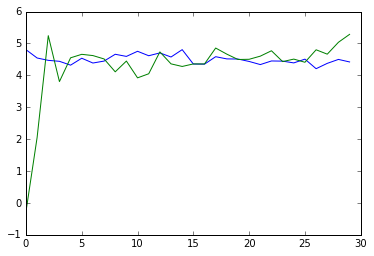

In [87]:

d_sampler = get_distribution_sampler(data_mean, data_stddev)
gi_sampler = get_generator_input_sampler()
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

epochs = []
fakes = []
reals = []

for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        d_real_data = Variable(d_sampler(d_input_size))
        d_real_decision = D(preprocess(d_real_data))
        d_real_error = criterion(d_real_decision, Variable(torch.ones(1)))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train D on fake
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
        d_fake_decision = D(preprocess(d_fake_data.t()))
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)))  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        g_fake_data = G(gen_input)
        dg_fake_decision = D(preprocess(g_fake_data.t()))
        g_error = criterion(dg_fake_decision, Variable(torch.ones(1)))  # we want to fool, so pretend it's all genuine

        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters

        
    if epoch % print_interval == 0:
        epochs.append(epoch)
        print("epoch %s"%epoch)
        reals.append(np.mean(extract(d_real_data)))
        fakes.append(np.mean(extract(d_fake_data)))
        #print("[%s]: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
                                                         #   extract(d_real_error)[0],
                                                         #   extract(d_fake_error)[0],
                                                         #   extract(g_error)[0],
                                                         #   stats(extract(d_real_data)),
                                                         #   stats(extract(d_fake_data))))
                            

                            
plt.plot(reals)
plt.plot(fakes)

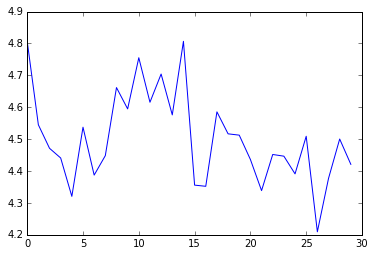

In [88]:
plt.plot(reals)

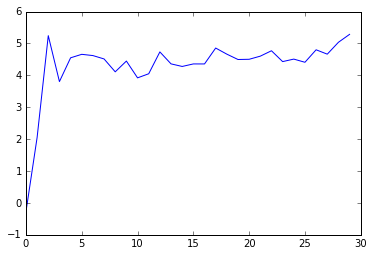

In [89]:
plt.plot(fakes)